In [ ]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 7.5 MB/s eta 0:00:00


# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tqdm

from hmmlearn import hmm

# Download dataset and Pre-processing steps

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Download the Fashion-MNIST dataset and labels
trainset = FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
testset = FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Define the data loaders
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

# Feature Extraction

1- CNN Model

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
#         self.dropout1 = nn.Dropout(p=0.5)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.dropout2 = nn.Dropout(p=0.5)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(64 * 7 * 7, 128)
#         self.dropout3 = nn.Dropout(p=0.5)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = nn.functional.relu(self.conv1(x))
#         x = self.dropout1(x)
#         x = self.pool(nn.functional.relu(self.conv2(x)))
#         x = self.dropout2(x)
#         x = self.pool(nn.functional.relu(self.conv3(x)))

#         x = x.view(-1, 64 * 7 * 7)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.dropout3(x)
#         x = self.fc2(x)
#         return x

2- CNN with Attention blocks

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-2)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma*out + x
        return out, attention

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.att1 = SelfAttention(16)
        self.dropout1 = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.att2 = SelfAttention(32)
        self.dropout2 = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.att3 = SelfAttention(64)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x, p1 = self.att1(x)
        x = self.dropout1(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x, p2 = self.att2(x)
        x = self.dropout2(x)
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x, p3 = self.att3(x)

        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

Train Feature Extraction Model

In [ ]:
# Train the CNN model on the Fashion-MNIST training data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CNN_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 40
train_loss = []
train_acc = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in tqdm.tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = CNN_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(trainset)
    epoch_acc = correct / total
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}")

100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 1/20, loss: 0.1055, accuracy: 0.9601


100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 2/20, loss: 0.0887, accuracy: 0.9664


100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 3/20, loss: 0.0757, accuracy: 0.9717


100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 4/20, loss: 0.0659, accuracy: 0.9753


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


Epoch 5/20, loss: 0.0556, accuracy: 0.9797


100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Epoch 6/20, loss: 0.0468, accuracy: 0.9830


100%|██████████| 118/118 [00:19<00:00,  5.93it/s]


Epoch 7/20, loss: 0.0372, accuracy: 0.9872


100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 8/20, loss: 0.0307, accuracy: 0.9893


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


Epoch 9/20, loss: 0.0282, accuracy: 0.9909


100%|██████████| 118/118 [00:20<00:00,  5.86it/s]


Epoch 10/20, loss: 0.0218, accuracy: 0.9933


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Epoch 11/20, loss: 0.0167, accuracy: 0.9948


100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 12/20, loss: 0.0135, accuracy: 0.9959


100%|██████████| 118/118 [00:19<00:00,  5.95it/s]


Epoch 13/20, loss: 0.0099, accuracy: 0.9975


100%|██████████| 118/118 [00:19<00:00,  5.91it/s]


Epoch 14/20, loss: 0.0123, accuracy: 0.9962


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Epoch 15/20, loss: 0.0093, accuracy: 0.9976


100%|██████████| 118/118 [00:19<00:00,  5.90it/s]


Epoch 16/20, loss: 0.0093, accuracy: 0.9973


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]


Epoch 17/20, loss: 0.0161, accuracy: 0.9950


100%|██████████| 118/118 [00:19<00:00,  5.92it/s]


Epoch 18/20, loss: 0.0090, accuracy: 0.9973


100%|██████████| 118/118 [00:19<00:00,  5.94it/s]


Epoch 19/20, loss: 0.0062, accuracy: 0.9983


100%|██████████| 118/118 [00:19<00:00,  5.96it/s]

Epoch 20/20, loss: 0.0054, accuracy: 0.9986


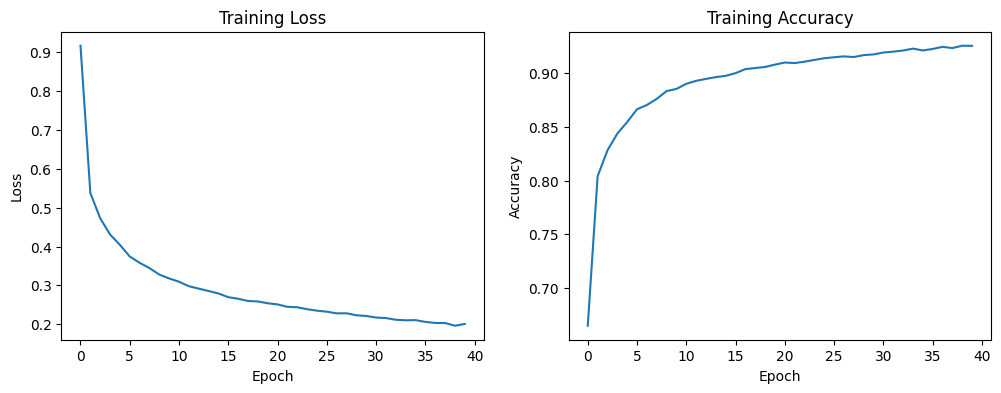

In [ ]:
# Plot the training loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_loss)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(train_acc)
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

Save the model

In [ ]:
!mkdir models

In [ ]:
# Save the CNN model
torch.save(CNN_model.state_dict(), 'models/CNN_model.pth')

Extract Features

In [ ]:
# Load the trained model
CNN_model.load_state_dict(torch.load('models/CNN_model.pth'))

# Extract feature vectors and labels for the Fashion-MNIST training data
CNN_model.eval()
train_features = []
train_labels = []
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        features = CNN_model(inputs).cpu().numpy()
        train_features.append(features)
        train_labels.append(labels.cpu().numpy())
train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

# Extract feature vectors and labels for the Fashion-MNIST test data
test_features = []
test_labels = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        features = CNN_model(inputs).cpu().numpy()
        test_features.append(features)
        test_labels.append(labels.cpu().numpy())
test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

In [ ]:
train_features.shape

(60000, 10)

In [ ]:
train_labels.shape

(60000,)

# HMM Classifiers

Train Classifiers

In [ ]:
# Train 10 HMMs for each class

num_states = 2 # number of hidden states for each HMM
num_classes = 10  # number of classes in the dataset
models = []  # list to store the HMM models

for c in range(num_classes):

    train_features_c = train_features[train_labels == c]
    model_c = hmm.GaussianHMM(n_components=num_states, covariance_type='diag')
    model_c.fit(train_features_c)
    while not model_c.monitor_.converged:
        model_c.fit(train_features_c, init_params='', verbose=False)
    models.append(model_c)

Model Inference

In [ ]:
predicted_labels = []
true_labels = []

thresholds = []

# Iterate over each test image
for test_feature, test_label in zip(test_features, test_labels):
    # Calculate log-likelihood scores for each class
    log_likelihoods = []
    for model in models:
        log_likelihood = model.score([test_feature]) # note that input to score should be 2D array
        log_likelihoods.append(log_likelihood)

    # Assign the test image to the class with the highest log-likelihood score
    predicted_label = np.argmax(log_likelihoods)
    predicted_labels.append(predicted_label)
    true_labels.append(test_label)

    # Calculate probability of each test image belonging to each class
    proba = np.exp(log_likelihoods) / np.sum(np.exp(log_likelihoods))

    thresholds.append(proba[1])

true_labels = np.array(true_labels, dtype=int)

# Calculate ROC curve and AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), thresholds, pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Results

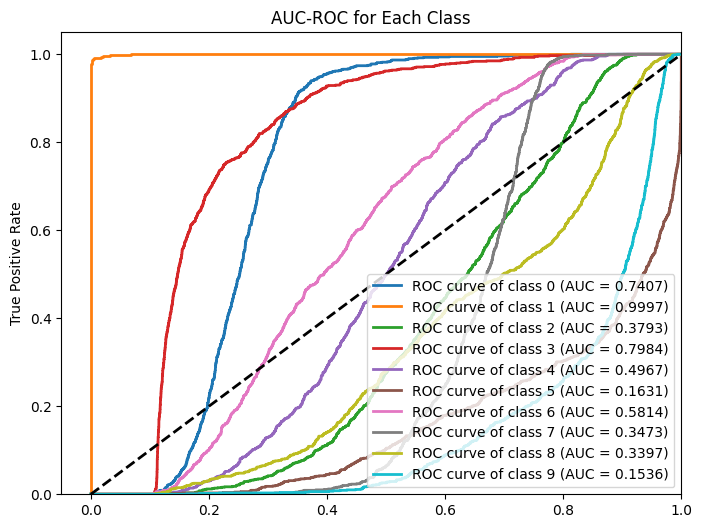

In [ ]:
# Plot AUC-ROC for each class
plt.figure(figsize=(8,6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %d (AUC = %0.4f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC for Each Class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate accuracy and f1 score
accuracy = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='macro')

# Print accuracy, F1 score, and AUC score for each class
for i in range(num_classes):
    print(f"AUC-ROC for class {i}: {roc_auc[i]:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 score: {f1:.4f}")

AUC-ROC for class 0: 0.7407
AUC-ROC for class 1: 0.9997
AUC-ROC for class 2: 0.3793
AUC-ROC for class 3: 0.7984
AUC-ROC for class 4: 0.4967
AUC-ROC for class 5: 0.1631
AUC-ROC for class 6: 0.5814
AUC-ROC for class 7: 0.3473
AUC-ROC for class 8: 0.3397
AUC-ROC for class 9: 0.1536
Accuracy: 0.8973
F1 score: 0.8966
